In [1]:
import numpy as np
from tqdm.notebook import tqdm
import random
import copy

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import model_selection, metrics, preprocessing

import torch
from torch import nn, optim, Tensor

from torch_sparse import SparseTensor, matmul

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.typing import Adj
from torch_geometric.nn.conv import MessagePassing

from scipy import sparse

In [2]:
# download the dataset
# https://grouplens.org/datasets/movielens/
# "Small: 100,000 ratings and 3,600 tag applications applied to 9,000 movies by 600 users. Last updated 9/2018"
url = r"https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"

extract_zip(download_url(url, "./data"), "./data")

movie_path = "./data/ml-latest-small/movies.csv"
rating_path = "./data/ml-latest-small/ratings.csv"
tag_path = "./data/ml-latest-small/tags.csv"

Using existing file ml-latest-small.zip
Extracting ./data\ml-latest-small.zip


In [3]:
rating_df = pd.read_csv(rating_path)

rating_df.head(3)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224


In [4]:
movie_df = pd.read_csv(movie_path)
tags_df = pd.read_csv(tag_path)

In [5]:
rating_df.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [6]:
# perform encoding preprocessing to ensure that user_id and item_id are both
# in the range of [0, unique_count] so it won't cause out of bound issue when indexing embeddings

lbl_user = preprocessing.LabelEncoder()
lbl_movie = preprocessing.LabelEncoder() 

rating_df.userId = lbl_user.fit_transform(rating_df.userId.values)
rating_df.movieId = lbl_movie.fit_transform(rating_df.movieId.values)

In [7]:
rating_df.userId.max(), rating_df.movieId.max()

(609, 9723)

In [8]:
rating_df.rating.value_counts()

rating
4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: count, dtype: int64

In [9]:
def load_edge_csv(df,
                src_index_col,
                dst_index_col,
                link_index_col,
                rating_threshold=3):
    """
    Load csv containing edges between users and items

    Args: 
        src_index_col (str): column name of users
        dst_index_col (str): column name of items
        link_index_col (str): column name of users items interactions
        rating threshold (int, optional): Threshold to determine positivity of edge. Defaults to 3.
    Return:
        list of lists: edge_index --2 by N matrix containing the node ids of N user-item edges
        N here is the number of interactions
    """

    edge_index = None

    # constructing COO format edge_index from input rating events

    # get user_ids from rating events in order of occurance 
    src = [user_id for user_id in df['userId']]
    # get movie_ids from rating events in order of occurance
    dst = [movie_id for movie_id in df['movieId']]

    # apply rating threshold
    edge_attr = torch.from_numpy(df[link_index_col].values).view(-1, 1).to(torch.long) >= rating_threshold

    edge_index = [[], []]
    for i in range(edge_attr.shape[0]):
        if edge_attr[i]:
            edge_index[0].append(src[i])
            edge_index[1].append(dst[i])

    return edge_index

In [10]:
edge_index = load_edge_csv(
    rating_df,
    'userId',
    'movieId',
    'rating', 
    3.5
)

f"{len(edge_index)} x {len(edge_index[0])}"

'2 x 48580'

In [11]:
# convert to tensor
# use LongTensor because .propagate() method in the model needs either LongTensor or SparseTensor

edge_index = torch.LongTensor(edge_index)
edge_index, edge_index.size(),edge_index.shape

(tensor([[   0,    0,    0,  ...,  609,  609,  609],
         [   0,    2,    5,  ..., 9443, 9444, 9445]]),
 torch.Size([2, 48580]),
 torch.Size([2, 48580]))

In [12]:
# note: this is total number of users and movies before apply the rating threshold
num_users = len(rating_df['userId'].unique())
num_movies = len(rating_df['movieId'].unique())

num_users, num_movies

(610, 9724)

In [13]:
num_interactions= edge_index.shape[1]

# split the edges of the graph using a 80/10/10 train/validation/test split

all_indices = [i for i in range(num_interactions)]

train_indices, test_indices = train_test_split(all_indices, 
                                               test_size=.2, 
                                               random_state=1)

val_indices, test_indices= train_test_split(test_indices,
                                           test_size=.5,
                                           random_state=1)

train_edge_index = edge_index[:, train_indices]
val_edge_index = edge_index[:, val_indices]
test_edge_index = edge_index[:, test_indices]

In [14]:
num_users, num_movies, num_interactions

(610, 9724, 48580)

In [15]:
train_edge_index, num_users + num_movies

(tensor([[ 605,  110,  442,  ...,   65,  161,  427],
         [1110, 9619, 1283,  ..., 4640,  443,  827]]),
 10334)

In [16]:
torch.unique(train_edge_index[0]).size(), torch.unique(train_edge_index[1]).size()

(torch.Size([609]), torch.Size([5676]))

In [17]:
def convert_r_mat_edge_index_to_adj_mat_edge_index(input_edge_index, row_size, col_size):
    R = torch.zeros((row_size, col_size))

    # convert sparse coo format to dense format to get R
    for i in range(len(input_edge_index[0])):
        row_idx = input_edge_index[0][i]
        col_idx = input_edge_index[1][i]
        R[row_idx][col_idx] = 1

    # perform the r_mat to adj_mat conversion
    R_transpose = torch.transpose(R, 0, 1)
    adj_mat = torch.zeros((row_size + col_size, row_size + col_size))
    adj_mat[: row_size, row_size :] = R.clone()
    adj_mat[row_size: , :row_size] = R_transpose.clone()

    # convert from dense format back to sparse coo format so we can get the edge_index of adj_mat
    adj_mat_coo = adj_mat.to_sparse_coo()
    adj_mat_coo = adj_mat_coo.indices()
    return adj_mat_coo

In [18]:
def convert_adj_mat_edge_index_to_r_mat_edge_index(input_edge_index, row_size, col_size):
    # create a sparse tensor so we can easily do the to_dense conversion and get a sub matrix to
    # get R (interation matrix) and then convert it back to sparse coo format
    sparse_input_edge_index = SparseTensor(row=input_edge_index[0],
                                           col=input_edge_index[1],
                                           sparse_sizes=((row_size + col_size), row_size + col_size))

    adj_mat = sparse_input_edge_index.to_dense()
    interact_mat = adj_mat[: row_size, row_size :]
    r_mat_edge_index = interact_mat.to_sparse_coo().indices()
    return r_mat_edge_index

In [19]:
# convert from r_mat edge index to adjacency matrix's edge index
# so we can feed it to the model


train_edge_index = convert_r_mat_edge_index_to_adj_mat_edge_index(train_edge_index,
                                                                 num_users, num_movies)
val_edge_index = convert_r_mat_edge_index_to_adj_mat_edge_index(val_edge_index,
                                                               num_users, num_movies)
test_edge_index = convert_r_mat_edge_index_to_adj_mat_edge_index(test_edge_index,
                                                                num_users, num_movies)

In [20]:
train_edge_index.size(), val_edge_index.size(), test_edge_index.size()

(torch.Size([2, 77728]), torch.Size([2, 9716]), torch.Size([2, 9716]))

In [72]:
train_edge_index[:, 0]

tensor([  0, 610], device='cuda:0')

In [79]:
train_edge_index[:, 0], train_edge_index[:, 0].shape

(tensor([  0, 610], device='cuda:0'), torch.Size([2]))

# Testing out the structured_negative_sampling

In [21]:
sns_test_edge_index = torch.as_tensor([[0, 0, 1, 2],
                                       [0, 1, 2, 3]])
structured_negative_sampling(sns_test_edge_index)

(tensor([0, 0, 1, 2]), tensor([0, 1, 2, 3]), tensor([2, 3, 0, 0]))

In [22]:
# helper function for training and compute BPR loss
'''
since this is a self-supervised learning, we are relying on the graph structure it self
we don't have label other than the graph structure so we need the following function 
which random samples a mini-batch of positive and negative samples
'''

def sample_mini_batch(batch_size, edge_index):
    """
    Randomly samples indices of a minibatch given an adjacency matrix 
    Args:
        batch_size (int): mini batch size
        edge_index (torch.Tensor): 2 by N list of edges
    """

    """
    structured_negative_sampling is a PyG library,
    Samples a negative edge: obj: '(i, k)' for every positive edge
    :obj: '(i, k)' in the graph given by: attr: 'edge_index', and returns it as 
    a tuple of the form :obj:'(i, j, k)'
        Check out the example above
    """
    edges = structured_negative_sampling(edge_index)

    # 3 x edge_index_len
    edges = torch.stack(edges, dim=0)

    # here is when we actually perform the batch samples
    # return a k sized list of population elements chosen with replacement
    indices = random.choices([i for i in range(edges[0].shape[0])], k=batch_size)
    
    batch = edges[:, indices]

    user_indices, pos_item_indices, neg_item_indices = batch[0], batch[1], batch[2]
    return user_indices, pos_item_indices, neg_item_indices

# Define Light GCN model

In [23]:
class LightGCN(MessagePassing):
    def __init__(self, num_users, num_items, embedding_dim=64, K=3, 
                add_self_loop=False):
        """
        Initialize the Light GCN model
        K (int, optional): number of messagepassing layers
        add_self_loop (bool, optional): wheter to add self loops for message passing.
        """
        super().__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.K = K
        self.add_self_loop = add_self_loop
    
    
        # define users and items embedding for direct look up
        # embedding dimension: num_users/items x embedding_dims
        # e_u^0
        self.users_emb = nn.Embedding(num_embeddings=self.num_users,
                                     embedding_dim=self.embedding_dim)
        # e_i ^ 0
        self.items_emb = nn.Embedding(num_embeddings=self.num_items,
                                      embedding_dim=self.embedding_dim)
    
        # Fills the input Tensor with values drawn from the normal distribution 
        # according to LightGCN paper, this given better performance
        nn.init.normal_(self.users_emb.weight, std=.1)
        nn.init.normal_(self.items_emb.weight, std=.1)


    def forward(self, edge_index: Tensor):
        """
        Forward propagation of LightGCN model 
        Args:
            edge_index: adjacency matrix
        Return: 
            tuple (Tensor): e_u_k, e_u_0, e_i_k, e_i_0
        """

        edge_index_norm = gcn_norm(edge_index=edge_index,
                                  add_self_loops=self.add_self_loop)
        # concat the user_emb and item_emb as the layer0 embedding matrix
        # size will be (n_users + n_items) x emb_vectors_len
        # E^0
        emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight])
        embs = [emb_0] # save the layer0 to the embs list

        # emb_k is the emb that we are actually going to push it through the graph layers
        # as described in LightGCN paper formular 7
        emb_k = emb_0

        # push the embedding of all users and items through the Graph Model K times
        # K here is the number of layers

        for i in range(self.K):
            emb_k = self.propagate(edge_index=edge_index_norm[0], 
                                   x=emb_k, norm=edge_index_norm[1])
            embs.append(emb_k)

        # this is doing the formular 8 in the LightGCN paper
        # stack embs is a list of embedding matrix at each layer
        # it's of shape n_nodes x (n_layers + 1) x emb_vector_len
        # e.g: torch.Size([10334, 4, 64])
        embs = torch.stack(embs, dim=1)

        # from lightgcn paper: "we find that setting a_k uniformly as 1/(K + 1) "
        # leads to good performance in general
        emb_final = torch.mean(embs, dim=1)  # E^K
        
        # split into e_u^K and e_i^K
        users_emb_final, items_emb_final = torch.split(emb_final, 
                                                       [self.num_users, self.num_items])

        # return e_u^K, e_u^0, e_i^K, e_i^0
        # here using .weight to get the tensor weights from nn.Embedding
        return users_emb_final, self.users_emb.weight, items_emb_final, self.items_emb.weight
    def message(self, x_j, norm):
        """
        x_j is of shape: edge_index_len x emb_vectors_len
        x_j is basically the embedding of all the neighbors based on the arc_list in coo edge index

        element_wise multiply by the symmetrically norm. So it's essential what formula 7 in LightGCN 
        paper does but here we are using edge_index rather that adj
        """

        return norm.view(-1, 1) * x_j

In [24]:
layers = 3

model = LightGCN(
    num_users=num_users,
    num_items=num_movies,
    K=layers
)

# Loss function

In [25]:
def bpr_loss(users_emb_final,
            users_emb_0,
            pos_items_emb_final,
            pos_items_emb_0,
            neg_items_emb_final,
            neg_items_emb_0,
            lambda_val):
    """
    Bayesian Personalized Ranking Loss as described in https://arxiv.org/abs/1205.2618

    Args:
        users_emb_fina (torch.Tensor): e_u_k
        users_emb_0 (torch.Tensor): e_u_0
        pos_items_emb_final (torch.Tensor): positive e_i_k
        pos_items_emb_0 (torch.Tensor): positive e_i_0
        neg_items_emb_final (torch.Tensor): negative e_i_k
        neg_items_emb_0 (torch.Tensor): negative e_i_0
        lambda_val (float): lambda value for regularization loss term
    """
    reg_loss = lambda_val * (users_emb_0.norm(2).pow(2) +
                             pos_items_emb_0.norm(2).pow(2) +
                             neg_items_emb_0.norm(2).pow(2)
                            )  # L2 loss

    pos_scores = torch.mul(users_emb_final, pos_items_emb_final)
    pos_scores = torch.sum(pos_scores, dim=-1)  # predicted scores of positive samples
    neg_scores = torch.mul(users_emb_final, neg_items_emb_final)
    neg_scores = torch.sum(neg_scores, dim=-1)  # predicted scores of negative samples

    bpr_loss = -torch.mean(torch.nn.functional.softplus(pos_scores - neg_scores))

    loss = bpr_loss + reg_loss

    return loss

In [26]:
def get_user_positive_items(edge_index):
    """
    Generates dictionary of positive items for each user
    Args:
        edge_index (torch.Tensor): 2 by N list of edges

    Return:
        dict: user -> list of positive items for each 
    """
    user_pos_items = {}

    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()

        if user not in user_pos_items:
            user_pos_items[user] = []

        user_pos_items[user].append(item)

    return user_pos_items

In [27]:
# compute recall2K and precision@K
def RecallPrecision_ATK(groundTruth, r, k):
    """
    Computes recall @K and precision @K
    Args:
        groundTruth (list[list[long]]): list of lists of items_ids. Cntaining highly rated items of each user.
            In other words, this is the list of true_relevant_items for each_user
        r (list[list[boolean]]): list of lists indicating whether each top k item recommended to each user
            is a top k ground truth (true relevant) item or not
        k (int): determine the top k items to compute precision and recall on
    Return: 
        tuple: recall @K, precision @K
    """
    # number of correctly predicted items per users
    # -1 here means I want to sum all at the inner most dimension
    num_correct_pred = torch.sum(r, dim=-1)

    # number of items liked by each user in the test set
    user_num_liked = torch.Tensor([len(groundTruth[i]) for i in range(len(groundTruth))])

    recall = torch.mean(num_correct_pred / user_num_liked)
    precision = torch.mean(num_correct_pred) / k

    return recall.item(), precision.item()

In [28]:
# computes NDCG@K 
def NDCGatK_r(groundTruth, r, k):
    """
    Compute Normalized Discounted Cumulative Gain (NDCG) @ K
    Args:
        groundTruth (list[list[long]]): list of lists of items_ids. Cntaining highly rated items of each user.
            In other words, this is the list of true_relevant_items for each_user
        r (list[list[boolean]]): list of lists indicating whether each top k item recommended to each user
            is a top k ground truth (true relevant) item or not
        k (int): determine the top k items to compute NDCG on
    Return: 
        float: ndcg @ k
    """
    assert len(r) == len(groundTruth)

    test_matrix = torch.zeros((len(r), k))

    for i, items in enumerate(groundTruth):
        length = min(len(items), k)
        test_matrix[i, :length] = 1
    max_r = test_matrix 
    idcg = torch.sum(max_r *  1./torch.log2(torch.arange(2, k + 2)), axis=1)
    dcg = r * (1. / torch.log2(torch.arange(2, k+2)))
    dcg = torch.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1
    ndcg = dcg / idcg
    ndcg[torch.isnan(ndcg)] = 0
    return torch.mean(ndcg).item()

In [29]:
# wrapper function to get the evaluation metrics
def get_metrics(model, 
                input_edge_index,  # adj_mat based edge_index
                input_edge_index_indices,  # adj_mat based excluded  edge index
                k):
    """
    Computes the evaluation metrics: recall, precision, ndcg
    Return: 
        tuple: recall, precision, ndcg @ k
    """

    # get the embedding tensor at layer 0 after training
    user_embedding = model.users_emb.weight
    item_embedding = model.items_emb.weight

    # convert adj_mat based edge_index to r_mat based 
    # so that we could have the first list being user_ids and second list being item_ids for edge index
    edge_index = convert_adj_mat_edge_index_to_r_mat_edge_index(input_edge_index, num_users, num_movies)

    # this is to exclude the edges we have seen before in our predicted interaction matrix (r_mat_rating)
    # for example: in validation set, we want to exclude all the edges in training set
    # print("exclude_edge_index",input_edge_index_indices.shape)
    exclude_edge_indices = [convert_adj_mat_edge_index_to_r_mat_edge_index(single_exclude_edge_index, num_users, num_movies) 
                            for single_exclude_edge_index in input_edge_index_indices]

    # generate predicted interaction matrix (r_mat_rating)
    # (num_users x 64) dot_product (num_items x 64).T 
    r_mat_rating = torch.matmul(user_embedding, item_embedding.T)

    rating = r_mat_rating

    for exclude_edge_index in exclude_edge_indices:
        # get all positive items for each user from the edge index
        # it's a dict: user -> positive items list
        user_pos_items = get_user_positive_items(exclude_edge_index)

        # get coordinates of all edges to exclude
        exclude_users = []
        exclude_items = []
        for user, items in user_pos_items.items():
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)

        # set the excluded entry in the rat_mat rating matrix to a very small number
        rating[exclude_users, exclude_items] = -(1 << 10)

    # get the top k recommended items for each user
    _, top_K_items = torch.topk(rating, k=k)

    # get all unique users in evaluated split
    users = edge_index[0].unique()

    # dict of user -> pos_items_lost
    test_user_pos_items = get_user_positive_items(edge_index)

    # convert test user pos items dictionary into a list of lists
    test_user_pos_items_list = [test_user_pos_items[user.item()] for user in users]

    # r here is 'pred_relevant_items' (combine with) 'actually_relevant_items' list for each user
    r = []
    for user in users:
        user_true_relevant_item = test_user_pos_items[user.item()]
        """
        list of boolean to stores whether or not a given item in the top_k_items for a given user
        is also present in user_true_relevant_item
        this is later on used to compute n_rel_and_rec_k
        """
        label = list(map(lambda x: x in user_true_relevant_item, top_K_items[user]))
        r.append(label)

    r = torch.Tensor(np.array(r).astype('float'))
    
    recall, precision = RecallPrecision_ATK(test_user_pos_items_list, r, k)
    ndcg = NDCGatK_r(test_user_pos_items_list, r, k)

    return recall, precision, ndcg

In [30]:
# wrapper function to evaluate model
def evaluation(model, 
              edge_index,
              exclude_edge_indices,
              k,
              lambda_val): 
    """
    Evaluate model loads and metrics including recall, precision, ndcg @k
    Return:
        tuple: bpr loss, recall, precision, ndcg
    """
    
    # get embeddings
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(edge_index)

    r_mat_edge_index = convert_adj_mat_edge_index_to_r_mat_edge_index(edge_index, num_users, num_movies)

    edges = structured_negative_sampling(r_mat_edge_index, contains_neg_self_loops=False)

    user_indices, pos_item_indices, neg_item_indices = edges[0], edges[1], edges[2]

    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]

    pos_item_emb_final, pos_item_emb_0 = items_emb_final[pos_item_indices], items_emb_final[pos_item_indices]

    neg_item_emb_final, neg_item_emb_0 = items_emb_final[neg_item_indices], items_emb_final[neg_item_indices]

    loss = bpr_loss(
        users_emb_final,
        users_emb_0,
        pos_item_emb_final,
        pos_item_emb_0,
        neg_item_emb_final,
        neg_item_emb_0,
        lambda_val
    ).item()

    recall, precision, ndcg = get_metrics(
        model,
        edge_index, 
        exclude_edge_indices,
        k
    )

    return loss, recall, precision, ndcg

# Training

In [31]:
ITERATIONS = 100000
EPOCHS=10
BATCH_SIZE=1024
LR=1e-3
ITERS_PER_EVAL = 200
ITERS_PER_LR_DECAY = 200
K = 40
LAMBDA = 1e-6

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = model.to(device)
model.train()

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=.95)

edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
val_edge_index = val_edge_index.to(device)

Using device: cuda


In [33]:
def get_embs_for_bpr(model, input_edge_index):
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(input_edge_index)

    edge_index_to_use = convert_adj_mat_edge_index_to_r_mat_edge_index(input_edge_index, num_users, num_movies)

    # mini-batching for eval and calculate loss
    user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(BATCH_SIZE, edge_index_to_use)

    # this is to push tensor to device so if we are using GPU
    user_indices, pos_item_indices, neg_item_indices = user_indices.to(device), pos_item_indices.to(device), neg_item_indices.to(device)

    # we need layer0 embeddings and the final embeddings (computed from 0 ... K layer) for BPR loss computing
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_item_emb_final, pos_item_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]
    neg_item_emb_final, neg_item_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]

    return users_emb_final, users_emb_0, pos_item_emb_final, pos_item_emb_0, neg_item_emb_final, neg_item_emb_0

In [35]:
# training loop
train_losses = []
val_losses = []
val_recall_at_ks = []

for iter_ in tqdm(range(ITERATIONS)):
    # forward propagation
    users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0 = get_embs_for_bpr(
        model,
        train_edge_index
    )

    # loss computation
    train_loss = bpr_loss(
        users_emb_final,
        users_emb_0,
        pos_items_emb_final,
        pos_items_emb_0,
        neg_items_emb_final,
        neg_items_emb_0,
        LAMBDA)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # validation set
    if iter_  % ITERS_PER_EVAL == 0:
        model.eval()

        with torch.no_grad():
            val_loss, recall, precision, ndcg = evaluation(
                model, 
                val_edge_index,
                (train_edge_index,),
                K,
                LAMBDA
            )
            print(f"Iteration {iter_}")
            print(f"train_loss: {round(train_loss.item(), 5)}|val_loss: {round(val_loss, 5)}")
            print(f"recall: {round(recall, 5)} | precision: {round(precision, 5)} | ndcg: {round(ndcg, 5)}")
            
            train_losses.append(train_loss.item())
            val_losses.append(val_loss)
            val_recall_at_ks.append(round(recall, 5))

        model.train()

    if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
        scheduler.step()

  0%|          | 0/10000 [00:00<?, ?it/s]

Iteration 0
train_loss: -0.69306|val_loss: -0.70534
recall: 0.0019 | precision: 0.00078 | ndcg: 0.00107
Iteration 200
train_loss: -6.97663|val_loss: -5.27821
recall: 0.09077 | precision: 0.02236 | ndcg: 0.05234
Iteration 400
train_loss: -31.75718|val_loss: -22.73145
recall: 0.10594 | precision: 0.02532 | ndcg: 0.06842
Iteration 600
train_loss: -71.3531|val_loss: -50.84377
recall: 0.12441 | precision: 0.0302 | ndcg: 0.08213
Iteration 800
train_loss: -117.84895|val_loss: -88.99235
recall: 0.14285 | precision: 0.03327 | ndcg: 0.08847
Iteration 1000
train_loss: -189.59256|val_loss: -135.34579
recall: 0.15547 | precision: 0.03412 | ndcg: 0.09744
Iteration 1200
train_loss: -257.22098|val_loss: -192.0405
recall: 0.15924 | precision: 0.03544 | ndcg: 0.09616
Iteration 1400
train_loss: -355.86481|val_loss: -254.68834
recall: 0.16542 | precision: 0.03611 | ndcg: 0.09965
Iteration 1600
train_loss: -456.03317|val_loss: -327.17581
recall: 0.16709 | precision: 0.03731 | ndcg: 0.10637
Iteration 1800
t

# Plot the curves

Text(0.5, 1.0, 'val recall')

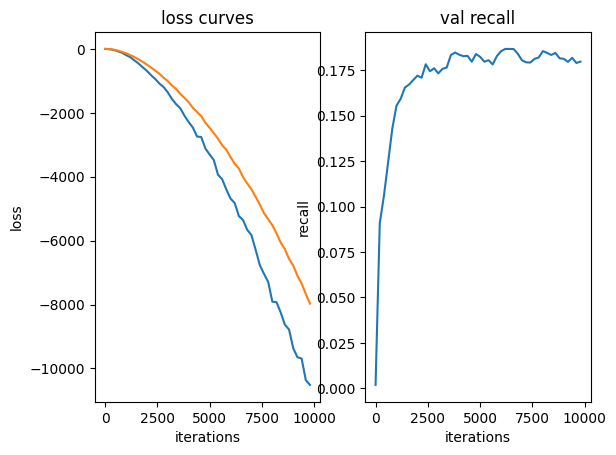

In [39]:
iters = [i * ITERS_PER_EVAL for i in range(len(train_losses))]

plt.subplot(1, 2, 1)
plt.plot(iters, train_losses, label='train_loss')
plt.plot(iters, val_losses, label='val_loss')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('loss curves')

plt.subplot(1, 2, 2)
plt.plot(iters, val_recall_at_ks, label='recall')
plt.xlabel('iterations')
plt.ylabel('recall')
plt.title('val recall')

In [41]:
# evaluate the model
model.eval()
test_edge_index = test_edge_index.to(device)

test_loss, test_recall, test_precision, test_ndcg = evaluation(
    model,
    test_edge_index,
    (train_edge_index, val_edge_index),
    K,
    LAMBDA
)

print('Test_loss:', test_loss)
print('Test_recall:', test_recall)
print('Test_precision:', test_precision)
print('Test_ndcg:', test_ndcg)

Test_loss: -8236.5205078125
Test_recall: 0.1665886789560318
Test_precision: 0.037922702729701996
Test_ndcg: 0.10849276185035706


# Experiencing Using the model

In [181]:
rand_user_idx = random.randint(0, 9000)
ground_truth = rating_df.iloc[rand_user_idx, :].to_frame().T
ground_truth

,userId,movieId,rating,timestamp
4744,27.0,6910.0,3.0,1.240816e+09


In [199]:
user_id_testing =  np.array(ground_truth.userId)[0]
user_id_testing, type(user_id_testing)

(27.0, numpy.float64)

In [200]:
rating_df[rating_df['userId'] == user_id_testing]

,userId,movieId,rating,timestamp
4194,27,5,3.5,1234570483
4195,27,15,2.5,1234570375
4196,27,20,3.0,1242290535
4197,27,22,1.5,1242290862
4198,27,30,2.5,1234334920
...,...,...,...,...
4759,27,7078,1.5,1277002289
4760,27,7103,2.5,1277001836
4761,27,7107,3.5,1277001895
4762,27,7168,2.0,1277002257


In [201]:
edge_index = test_edge_index
input_edge_index_indices = (train_edge_index, )
k = 10

# get the embedding tensor at layer 0 after training
user_embedding = model.users_emb.weight
item_embedding = model.items_emb.weight

edge_index = convert_adj_mat_edge_index_to_r_mat_edge_index(edge_index, num_users, num_movies)

exclude_edge_indices = [convert_adj_mat_edge_index_to_r_mat_edge_index(single_exclude_edge_index, num_users, num_movies) 
                        for single_exclude_edge_index in input_edge_index_indices]

r_mat_rating = torch.matmul(user_embedding, item_embedding.T)

rating = r_mat_rating

for exclude_edge_index in exclude_edge_indices:
    # get all positive items for each user from the edge index
    # it's a dict: user -> positive items list
    user_pos_items = get_user_positive_items(exclude_edge_index)

    # get coordinates of all edges to exclude
    exclude_users = []
    exclude_items = []
    for user, items in user_pos_items.items():
        exclude_users.extend([user] * len(items))
        exclude_items.extend(items)

    # set the excluded entry in the rat_mat rating matrix to a very small number
    rating[exclude_users, exclude_items] = -(1 << 10)

# get the top k recommended items for each user
_, top_K_items = torch.topk(rating, k=k)

# get all unique users in evaluated split
users = edge_index[0].unique()

# dict of user -> pos_items_lost
test_user_pos_items = get_user_positive_items(edge_index)

# convert test user pos items dictionary into a list of lists
test_user_pos_items_list = [test_user_pos_items[user.item()] for user in users]

In [202]:
len(test_user_pos_items)

552

In [203]:
len(test_user_pos_items_list)

552

In [208]:
user_lst = test_user_pos_items_list[int(user_id_testing)]
user_lst

[277, 6726, 7022, 8358, 8420]

In [210]:
rating_df[(rating_df['userId'] == user_id_testing) & (rating_df['movieId'].isin(user_lst))]

,userId,movieId,rating,timestamp
4218,27,277,3.5,1234338000
4702,27,6726,4.5,1234338546


In [212]:
rating_df[rating_df['movieId'].isin(user_lst)].describe()

,userId,movieId,rating,timestamp
count,633.000000,633.000000,633.000000,6.330000e+02
mean,305.107425,3851.464455,4.187204,1.312099e+09
std,180.165758,3620.298538,0.819623,2.237169e+08
min,1.000000,277.000000,0.500000,8.297609e+08
25%,140.000000,277.000000,3.500000,1.204048e+09
50%,306.000000,277.000000,4.500000,1.429127e+09
75%,463.000000,7022.000000,5.000000,1.478452e+09
max,609.000000,8420.000000,5.000000,1.537158e+09
